# Gesture Recognition Case Study
## Problem Statement
Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote. 
The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

1. Thumbs up:  Increase the volume
2. Thumbs down: Decrease the volume
3. Left swipe: 'Jump' backwards 10 seconds
4. Right swipe: 'Jump' forward 10 seconds  
5. Stop: Pause the movie
 

The training data consists of a few hundred videos categorised into one of the five classes. Each video (typically 2-3 seconds long) is divided into a sequence of 30 frames(images). These videos have been recorded by various people performing one of the five gestures in front of a webcam - similar to what the smart TV will use. 

## Step 1 : Environment Set-up

### Google Collab Set-up Code

#### Mounting Google Drive to Google Collab

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


#### Uploading data to Google Collab and unzipping

In [0]:
zip_path = '/content/drive/My Drive/Project_data.zip'
!cp '{zip_path}' .
!unzip -q Project_data.zip
!rm Project_data.zip

#### Choosing Tensorflow 1.x version

In [3]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


### Installing additional used libs

In [0]:
!pip install googledrivedownloader

### Importing libs

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
import os
import warnings

# We set the random seed so that the results don't vary drastically.
import numpy as np
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
import keras
tf.set_random_seed(30)

from skimage import io
from skimage.transform import resize

from google_drive_downloader import GoogleDriveDownloader as gdd

from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout 
from keras.layers import ConvLSTM2D, Input
from keras.layers.pooling import GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.layers.recurrent import LSTM
from keras.layers.wrappers import TimeDistributed
from keras.layers.convolutional import Conv3D, MaxPooling3D, MaxPooling2D

from keras import optimizers

from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, LearningRateScheduler

from keras import applications

from keras.regularizers import l2

warnings.filterwarnings("ignore")

Using TensorFlow backend.


### Verifying libs version

Implementations are successfully executing on following versions

In [0]:
## Tensorflow - 1.15
tf.__version__

'1.15.2'

## Step 2 : Data Sourcing

### Reading data

In [5]:
source_path = './Project_data'
train_path = source_path + '/train'
val_path = source_path + '/val'

train_doc = np.random.permutation(open(source_path + '/train.csv').readlines())
val_doc = np.random.permutation(open(source_path + '/val.csv').readlines())

num_train_sequences = len(train_doc)
print('Total training videos : {}'.format(num_train_sequences))

num_val_sequences = len(val_doc)
print('Total validation videos : {}'.format(num_val_sequences))

num_classes = 5

curr_dt_time = datetime.datetime.now()

Total training videos : 663
Total validation videos : 100


### Selecting images from sequence

After multiple iterations with 12, 15, 16, 18, 21, 24, 30 images per sequence, using all images at initial layers for feature extraction seems to be providing optimum accuracy. To keep parameters in check, following layers were adjusted accordingly. 

In [6]:
selected_images_index = []
selected_images_index.extend(range(30))
print(selected_images_index)
total_selected_images = len(selected_images_index)
print ('# total_selected_images =', total_selected_images)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
# total_selected_images = 30


### Defining input shape

After multiple iterations with image size of 80 * 80, 100 * 100, 120 * 120, image size 120 * 120 seems to be providing optimum accuracy. To keep parameters in check, following layers were adjusted accordingly. 

In [7]:
input_shape = (total_selected_images, 120, 120, 3)
print ('# input_shape =', input_shape)

# input_shape = (30, 120, 120, 3)


## Step 3 : Generator

### Defining Generator

Following implementation allows use of multi-processing and to be used with more than 1 worker, resulting into some performance improvement in loading data for running epochs.

In [0]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'

    def __init__(self, source_path, sequence_list, ablation=None,
                 batch_size=16, dims=(120, 120), n_channels=3, 
                 selected_images_index = [], shuffle=True, 
                 gen_horizontal_flipped_seq = True, 
                 normalize_img = True, 
                 preprocess_for_pretrained_resnet = False,
                 preprocess_for_pretrained_mobilenet = False,
                 debug = False):
        """
        Initialise the data generator
        """
        self.source_path = source_path
        self.sequence_list = sequence_list
        self.ablation = ablation
        self.batch_size = batch_size
        self.dims = dims
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.debug = debug
        
        self.gen_horizontal_flipped_seq = gen_horizontal_flipped_seq
        self.normalize_img = normalize_img
        self.preprocess_for_pretrained_resnet = preprocess_for_pretrained_resnet
        self.preprocess_for_pretrained_mobilenet = preprocess_for_pretrained_mobilenet
        self.generator_type = self.get_generator_type()
        
        self.labels = self.get_class_dict()
        self.num_classes = len(self.labels)

        self.effective_batch_size = batch_size
        
        self.selected_images_index = selected_images_index
        self.seq_length = len(self.selected_images_index)

        if self.gen_horizontal_flipped_seq and self.generator_type == 'train':
            self.effective_batch_size = int(batch_size / 2)

        if (self.seq_length == 0):
            self.selected_images_index = [i for i in range(30)]
            self.seq_length = 30
        
        if self.ablation is not None:
            self.sequence_list = self.sequence_list[:self.ablation]
            
        self.docs_dict = self.get_docs_dict()
            
        if self.debug:
            self.plot_docs_dict(self.docs_dict)
        
        self.total_sequences = len(self.sequence_list)

        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'        
        if (self.total_sequences%self.effective_batch_size) == 0:
            steps_per_epoch = int(np.floor(self.total_sequences / self.effective_batch_size))
        else:
            steps_per_epoch = int(np.floor(self.total_sequences//self.effective_batch_size)) + 1
            
        if self.debug:
            print('Number of sequences : {}'.format(self.total_sequences))
            print('Effective Batch size : {}'.format(self.effective_batch_size))
            print('Number of batches per epoch in training : {}'.format(steps_per_epoch))    
    
        return steps_per_epoch
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.debug:
            print('\nRandomizing sequences for {}....'.format(self.generator_type))
        self.indexes = np.arange(len(self.sequence_list))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        start = index*self.effective_batch_size
        end = (index+1)*self.effective_batch_size
        indexes = self.indexes[start:end]
        processing_seq = len(indexes)
        
        batch_size = self.batch_size
        if end > self.total_sequences:
            batch_size = processing_seq
            if self.gen_horizontal_flipped_seq:
                batch_size = 2*batch_size

        if self.debug:
            print('Processing sequences from : {}-{}'.format(start, end - 1))
            print('Total sequences to be processed : {}'.format(processing_seq))
            print('Batch size : {}'.format(batch_size))

        # Find list of IDs
        sequence_list = [self.sequence_list[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(sequence_list, batch_size)
        
        if self.preprocess_for_pretrained_resnet:
            X = applications.resnet50.preprocess_input(X)

        elif self.preprocess_for_pretrained_mobilenet:
            X = applications.mobilenet_v2.preprocess_input(X)

        return X, y
        
    
    def __data_generation(self, sequences, batch_size):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        
        batch_data = np.zeros((batch_size, self.seq_length, self.dims[0], self.dims[1], self.n_channels))

        # batch_labels is the one hot representation of the output

        batch_labels = np.zeros((batch_size, self.num_classes)) 

        for index, sequence in enumerate(sequences): # iterate over the batch_size
            sequence = sequence.split(';')
            sequence_name = sequence[0]
            label = sequence[2]
            # read all the images in the folder
            imgs = self.get_images_for_sequence(sequence_name)
                
            if self.gen_horizontal_flipped_seq and self.generator_type == 'train':
                if self.debug:
                    print('Generating horizontal flipped sequence for image : {}'.format(index + 1))
                    
                index = 2*index
                new_label, horizontal_flipped_imgs = self.get_horizontal_flipped_sequence(int(label), imgs)
                batch_data[index + 1,:] = self.get_sequence_data(horizontal_flipped_imgs)
                batch_labels[index + 1, int(new_label)] = 1
            
            batch_data[index,:] = self.get_sequence_data(imgs)
            batch_labels[index, int(label)] = 1

        if self.debug:
            print('\nFetching Batch Data of Shape for {} : {}'.format(self.generator_type, batch_data.shape))
        return batch_data, batch_labels 
    
    def get_horizontal_flipped_sequence(self, label, images):
        new_label = label

        if label == 0:
            new_label = 1

        if label == 1:
            new_label = 0

        return (new_label, [np.fliplr(image) for image in images])

    def read_sequence(self, sequence):
        imgs = sorted(os.listdir(self.source_path + '/' + sequence))
        return imgs

    def get_images_for_sequence(self, sequence_folder_name):
        return [io.imread(self.source_path + '/' + sequence_folder_name + '/' + sequence_image)
                for sequence_image in self.read_sequence(sequence_folder_name)]  

    def get_generator_type(self):
        source_path_value = self.source_path.split('/')
        generator_type = source_path_value[len(source_path_value) - 1]
        return generator_type

    def get_sequence_data(self, imgs):
        if self.preprocess_for_pretrained_resnet | self.preprocess_for_pretrained_mobilenet:
            self.normalize_img = False
            return self.get_sequence_data_from_images(imgs)
        else:
            return self.get_sequence_data_from_images(imgs)

    def get_sequence_data_from_images(self, imgs):   
        y = self.dims[0]
        z = self.dims[1]

        sequence_data = np.zeros((self.seq_length, y, z, self.n_channels))

        #  Iterate over the frames/images of a folder to read them in
        for idx, item in enumerate(self.selected_images_index): 
            image = imgs[item].astype(np.float32)
            #crop the images and resize them. Note that the images are of 2 different shape 
            #and the conv3D will throw error if the inputs in a batch have different shapes
            image = resize(image, (y,z))
            img_channel_1 = image[:,:,0]
            img_channel_2 = image[:,:,1]
            img_channel_3 = image[:,:,2]
            
            if self.normalize_img:
                img_channel_1 = (image[:,:,0] - np.min(image[:,:,0])) / np.ptp(image[:,:,0])
                img_channel_2 = (image[:,:,1] - np.min(image[:,:,1])) / np.ptp(image[:,:,1])
                img_channel_3 = (image[:,:,2] - np.min(image[:,:,2])) / np.ptp(image[:,:,2])
            
            #normalise and feed in the image
            sequence_data[idx,:,:,0] = img_channel_1
            #normalise and feed in the image
            sequence_data[idx,:,:,1] = img_channel_2
            #normalise and feed in the image
            sequence_data[idx,:,:,2] = img_channel_3
            
        return sequence_data
    
    def get_docs_dict(self):
        docs = [sequence.split(';') if isinstance(sequence, str) else sequence for sequence in self.sequence_list]
        
        doc_dict = {int(sequence[2][0]):[] for sequence in docs}

        for sequence in docs:
            folder_name = sequence[0]
            class_value = sequence[2][0]
            doc_dict.get(int(class_value)).append(sequence)

        return doc_dict
    
    def get_class_dict(self):
        docs = [sequence.split(';') if isinstance(sequence, str) else sequence for sequence in self.sequence_list]
        class_labels = set(sequence[1] for sequence in docs)

        doc_classes = {int(sequence[2][0]):sequence[1] for sequence in docs}
        
        if self.debug:
            print('Class Labels : {}'.format(class_labels))
            print('\nClasses : {}'.format(doc_classes))
            
        return doc_classes
        
    
    def plot_images(self, class_label, images, plt_clip_to_valid_range = False):
        fig = plt.figure(figsize=(20,5))
        for i,image in enumerate(images):
            ax = fig.add_subplot(2, int(len(images)/2), 1 + i, xticks=[], yticks=[])
            
            if plt_clip_to_valid_range:
                plt.imshow(np.uint8(image))
            else:
                plt.imshow(image)
                
            fig.suptitle(class_label)

        plt.show()

    def plot_sequence(self, label):
        docs = self.docs_dict.get(label)
        doc_sequence = np.random.permutation(docs)
        sequence_folder_name = doc_sequence[0][0]
        class_name = doc_sequence[0][1]
        class_label = int(doc_sequence[0][2])
        
        if self.debug:
            print('Sequence Folder Name : {}'.format(sequence_folder_name))

        images = self.get_images_for_sequence(sequence_folder_name)

        self.plot_images(class_name, images)

        if len(self.selected_images_index) > 0 and len(self.selected_images_index) < len(images):
            selected_images = [image for index, image in enumerate(images)
                               if index in self.selected_images_index]
            self.plot_images(class_name, selected_images)

        if self.gen_horizontal_flipped_seq:
            new_class_label, flipped_images = self.get_horizontal_flipped_sequence(class_label, images)
            self.plot_images(self.labels.get(new_class_label), flipped_images)

    def plot_docs_dict(self, docs_dict):
        class_samples = {key: len(values) for key,values in docs_dict.items()}
        if self.debug:
            print(class_samples)
        plt.bar(class_samples.keys(), class_samples.values())
        plt.show()

### Defining Common methods to test Generator

In [0]:
def test_generator(generator, plt_clip_to_valid_range = False):
    total_batch = generator.__len__()
    for batch_number in range(total_batch):
        batch_data, batch_labels = generator.__getitem__(batch_number)
        print(batch_labels)
        images = batch_data[0]
        class_label = batch_labels[0]
        train_generator.plot_images(class_label, images, plt_clip_to_valid_range)

### Checking class distribution for sequences

Class Labels : {'Thumbs Down_new', 'Thumbs_Up_new', 'Thumbs_Down_new', 'Right Swipe_new', 'Left_Swipe_new', 'Thumbs Up_new', 'Right_Swipe_new', 'Left Swipe_new_Left Swipe_new', 'Stop_new', 'Stop Gesture_new'}

Classes : {1: 'Right_Swipe_new', 3: 'Thumbs_Down_new', 0: 'Left Swipe_new_Left Swipe_new', 4: 'Thumbs_Up_new', 2: 'Stop_new'}
{1: 137, 3: 137, 0: 136, 4: 123, 2: 130}


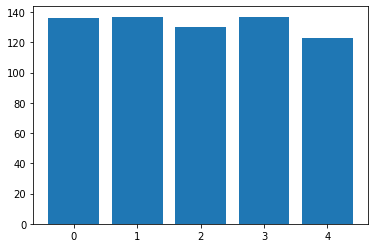


Randomizing sequences for train....
Class Labels : {'Thumbs Down_new', 'Thumbs_Up_new', 'Thumbs_Down_new', 'Right Swipe_new', 'Thumbs Up_new', 'Left_Swipe_new', 'Right_Swipe_new', 'Left Swipe_new_Left Swipe_new', 'Stop_new', 'Stop Gesture_new'}

Classes : {3: 'Thumbs_Down_new', 4: 'Thumbs_Up_new', 2: 'Stop_new', 0: 'Left_Swipe_new', 1: 'Right_Swipe_new'}
{3: 21, 4: 16, 2: 22, 0: 18, 1: 23}


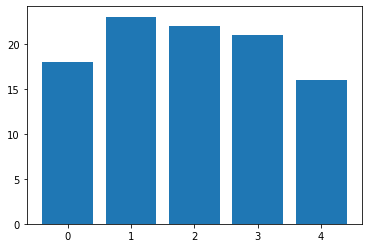


Randomizing sequences for val....


In [0]:
train_generator = DataGenerator(train_path, train_doc, debug = 1)
val_generator = DataGenerator(val_path, val_doc, debug = 1)

### Plotting sample train sequences

In [0]:
for class_label in train_generator.labels:
    train_generator.plot_sequence(class_label)

Output hidden; open in https://colab.research.google.com to view.

### Testing Generator

#### For Ground Up Networks

##### With horizontal flipped sequence

Class Labels : {'Thumbs Down_new', 'Thumbs_Up_new', 'Thumbs_Down_new', 'Right Swipe_new', 'Left_Swipe_new', 'Thumbs Up_new', 'Right_Swipe_new', 'Left Swipe_new_Left Swipe_new', 'Stop_new', 'Stop Gesture_new'}

Classes : {1: 'Right_Swipe_new', 3: 'Thumbs_Down_new', 0: 'Left Swipe_new_Left Swipe_new', 4: 'Thumbs_Up_new', 2: 'Stop_new'}
{1: 1, 3: 1, 0: 2, 4: 1}


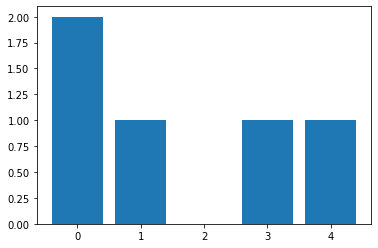


Randomizing sequences for train....
Number of sequences : 5
Effective Batch size : 2
Number of batches per epoch in training : 3
Processing sequences from : 0-1
Total sequences to be processed : 2
Batch size : 4
Generating horizontal flipped sequence for image : 1
Generating horizontal flipped sequence for image : 2

Fetching Batch Data of Shape for train : (4, 30, 120, 120, 3)
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]


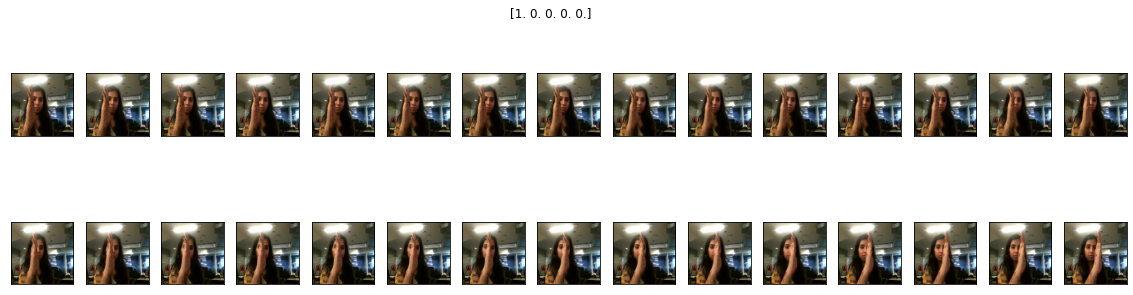

Processing sequences from : 2-3
Total sequences to be processed : 2
Batch size : 4
Generating horizontal flipped sequence for image : 1
Generating horizontal flipped sequence for image : 2

Fetching Batch Data of Shape for train : (4, 30, 120, 120, 3)
[[0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]]


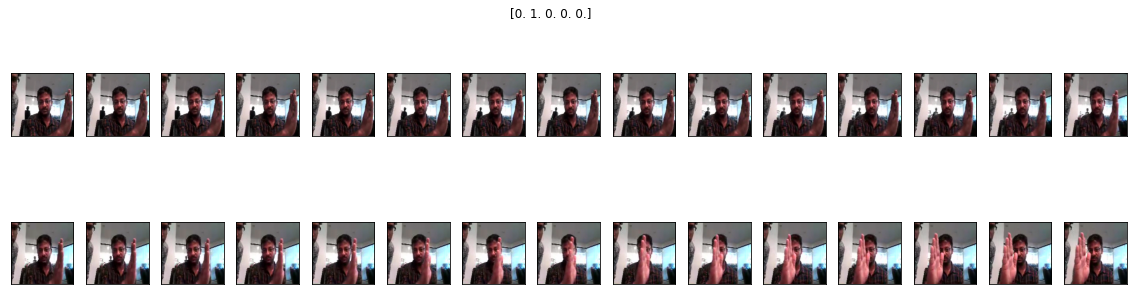

Processing sequences from : 4-5
Total sequences to be processed : 1
Batch size : 2
Generating horizontal flipped sequence for image : 1

Fetching Batch Data of Shape for train : (2, 30, 120, 120, 3)
[[0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]


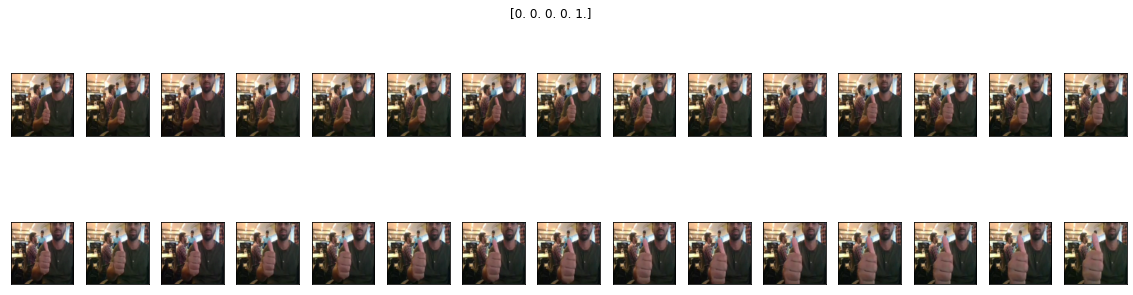

In [0]:
batch_generator = DataGenerator(train_path, train_doc, 5, 4, debug = True)

test_generator(batch_generator)

##### Without horizontal flipped sequence

Class Labels : {'Thumbs Down_new', 'Thumbs_Up_new', 'Thumbs_Down_new', 'Right Swipe_new', 'Left_Swipe_new', 'Thumbs Up_new', 'Right_Swipe_new', 'Left Swipe_new_Left Swipe_new', 'Stop_new', 'Stop Gesture_new'}

Classes : {1: 'Right_Swipe_new', 3: 'Thumbs_Down_new', 0: 'Left Swipe_new_Left Swipe_new', 4: 'Thumbs_Up_new', 2: 'Stop_new'}
{1: 1, 3: 1, 0: 2, 4: 1}


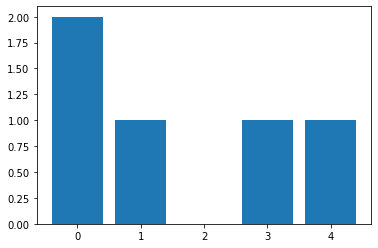


Randomizing sequences for train....
Number of sequences : 5
Effective Batch size : 4
Number of batches per epoch in training : 2
Processing sequences from : 0-3
Total sequences to be processed : 4
Batch size : 4

Fetching Batch Data of Shape for train : (4, 30, 120, 120, 3)
[[0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]]


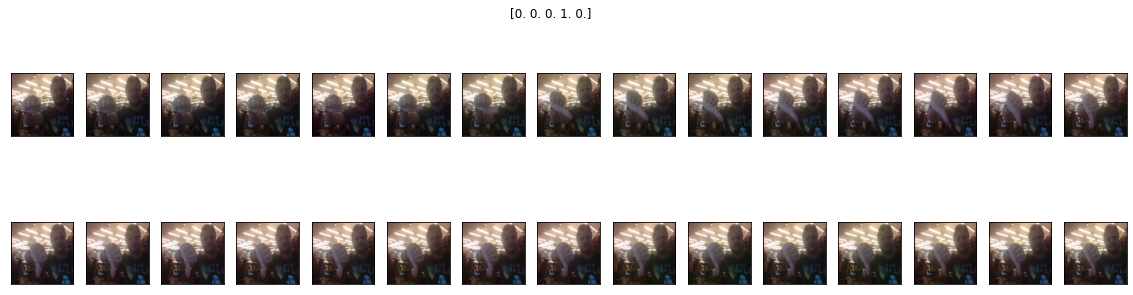

Processing sequences from : 4-7
Total sequences to be processed : 1
Batch size : 1

Fetching Batch Data of Shape for train : (1, 30, 120, 120, 3)
[[1. 0. 0. 0. 0.]]


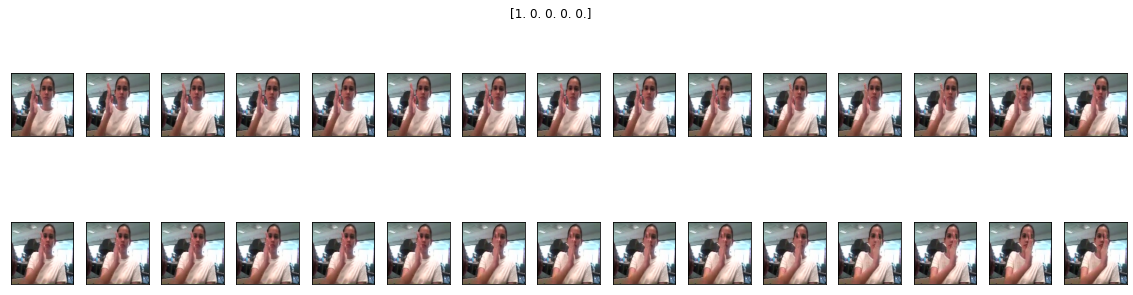

In [0]:
batch_generator = DataGenerator(train_path, train_doc, 5, 4, debug = True, 
                                gen_horizontal_flipped_seq = False)

test_generator(batch_generator)

#### For Pre-trained 

##### With horizontal flipped sequence

Class Labels : {'Thumbs Down_new', 'Thumbs_Up_new', 'Thumbs_Down_new', 'Right Swipe_new', 'Left_Swipe_new', 'Thumbs Up_new', 'Right_Swipe_new', 'Left Swipe_new_Left Swipe_new', 'Stop_new', 'Stop Gesture_new'}

Classes : {1: 'Right_Swipe_new', 3: 'Thumbs_Down_new', 0: 'Left Swipe_new_Left Swipe_new', 4: 'Thumbs_Up_new', 2: 'Stop_new'}
{1: 1, 3: 1, 0: 2, 4: 1}


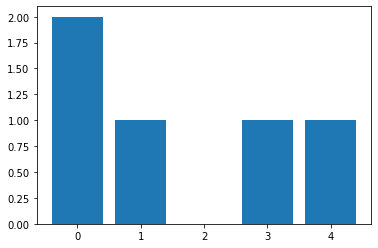


Randomizing sequences for train....
Number of sequences : 5
Effective Batch size : 2
Number of batches per epoch in training : 3
Processing sequences from : 0-1
Total sequences to be processed : 2
Batch size : 4
Generating horizontal flipped sequence for image : 1
Generating horizontal flipped sequence for image : 2

Fetching Batch Data of Shape for train : (4, 30, 120, 120, 3)
[[0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]]


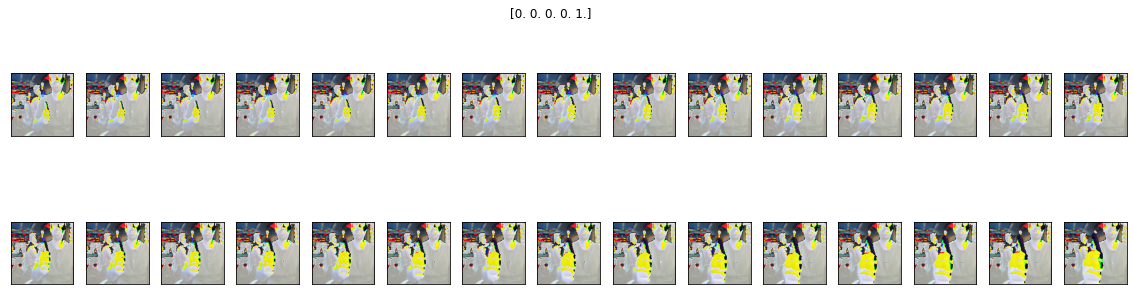

Processing sequences from : 2-3
Total sequences to be processed : 2
Batch size : 4
Generating horizontal flipped sequence for image : 1
Generating horizontal flipped sequence for image : 2

Fetching Batch Data of Shape for train : (4, 30, 120, 120, 3)
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]


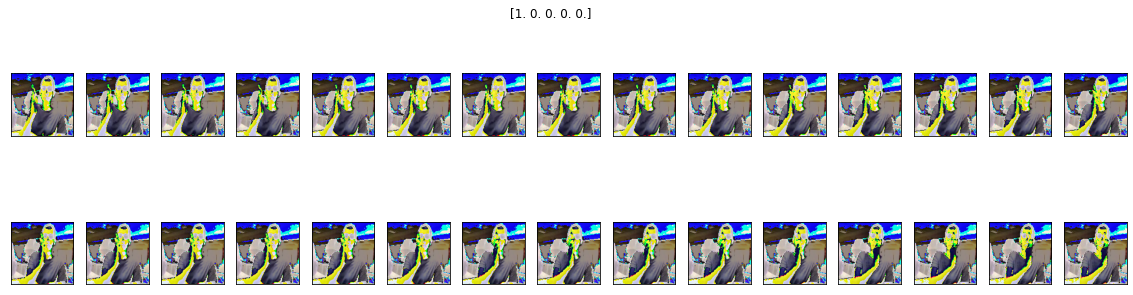

Processing sequences from : 4-5
Total sequences to be processed : 1
Batch size : 2
Generating horizontal flipped sequence for image : 1

Fetching Batch Data of Shape for train : (2, 30, 120, 120, 3)
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]


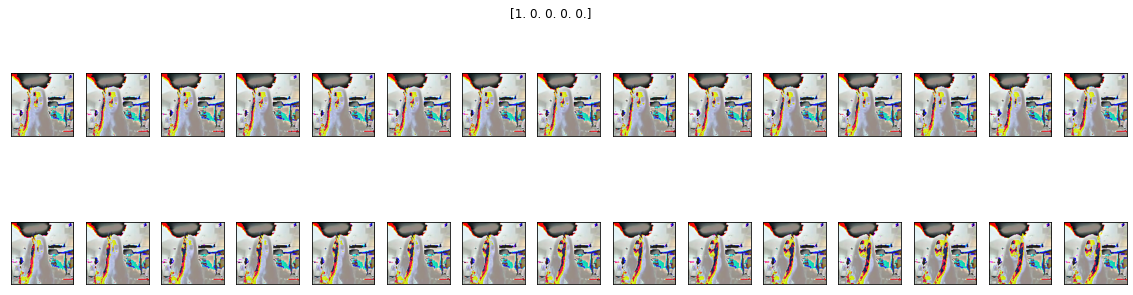

In [0]:
batch_generator = DataGenerator(train_path, train_doc, 5, 4, debug = True, preprocess_for_pretrained_resnet = True)

test_generator(batch_generator, True)

##### Without horizontal flipped sequence

Class Labels : {'Thumbs Down_new', 'Thumbs_Up_new', 'Thumbs_Down_new', 'Right Swipe_new', 'Left_Swipe_new', 'Thumbs Up_new', 'Right_Swipe_new', 'Left Swipe_new_Left Swipe_new', 'Stop_new', 'Stop Gesture_new'}

Classes : {1: 'Right_Swipe_new', 3: 'Thumbs_Down_new', 0: 'Left Swipe_new_Left Swipe_new', 4: 'Thumbs_Up_new', 2: 'Stop_new'}
{1: 1, 3: 1, 0: 2, 4: 1}


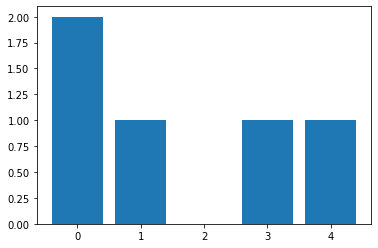


Randomizing sequences for train....
Number of sequences : 5
Effective Batch size : 4
Number of batches per epoch in training : 2
Processing sequences from : 0-3
Total sequences to be processed : 4
Batch size : 4

Fetching Batch Data of Shape for train : (4, 30, 120, 120, 3)
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


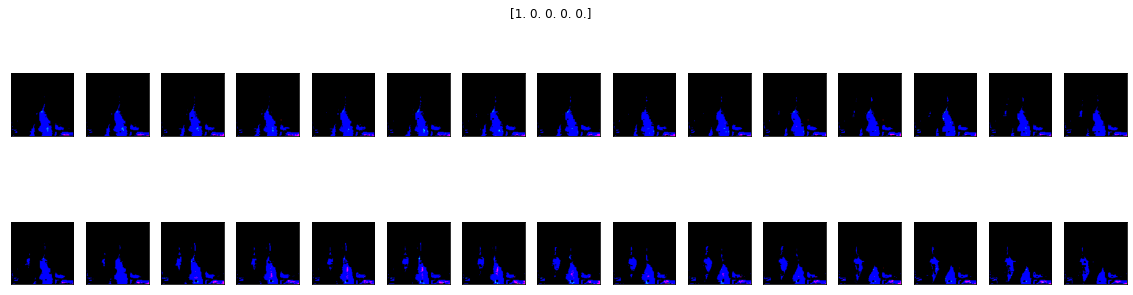

Processing sequences from : 4-7
Total sequences to be processed : 1
Batch size : 1

Fetching Batch Data of Shape for train : (1, 30, 120, 120, 3)
[[0. 1. 0. 0. 0.]]


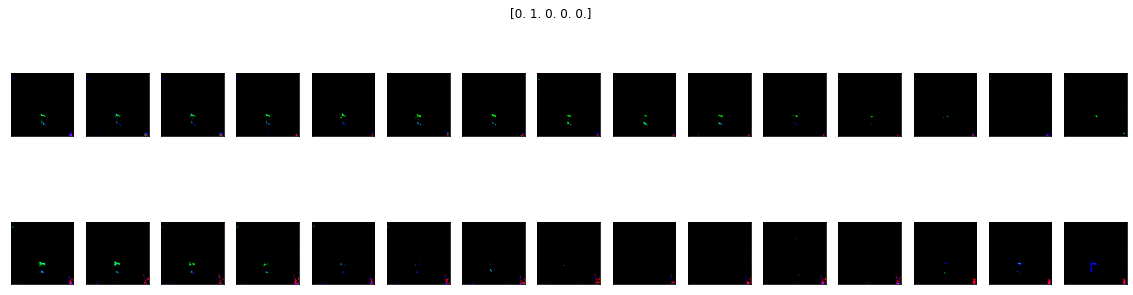

In [0]:
batch_generator = DataGenerator(train_path, train_doc, 5, 4, debug = True, 
                                preprocess_for_pretrained_mobilenet = True, 
                                gen_horizontal_flipped_seq = False)

test_generator(batch_generator, True)

## Step 4 : Modelling

### Defining common functions

In [0]:
def get_file_path(model_path, on_g_drive = False):
    filepath = './'
      
    if on_g_drive:
        filepath = '/content/drive/My Drive/'

    if model_path.split('.')[-1] != 'h5':
        model_path = '{}.h5'.format(model_path)

    filepath = filepath + model_path

    return filepath

def save_generated_model(model_path, model, save_on_g_drive = False):
    filepath = get_file_path(model_path, save_on_g_drive)
    model.save(filepath)
    
def load_saved_model(saved_model_path, saved_on_g_drive = False):
    filepath = get_file_path(saved_model_path, saved_on_g_drive)
    model  = load_model(filepath)

    print(model.summary())
    
    return model
    
def evaluate_model(saved_model_path, val_generator, saved_on_g_drive = False):        
    model  = load_saved_model(saved_model_path, saved_on_g_drive)
    evaluation_metrics = model.evaluate_generator(val_generator, verbose = 1)
    print('Model Evaluation :')
    print('Validation Loss : {}'.format(evaluation_metrics[0]))
    print('Validation Accuracy : {}'.format(evaluation_metrics[1]))

def download_saved_model(file_id, save_model_path, save_on_g_drive = False):
    filepath = get_file_path(save_model_path, save_on_g_drive)
    if not os.path.exists(filepath):
        gdd.download_file_from_google_drive(file_id, dest_path = filepath)
    else:
        print('Model already downloaded !!')

def plot_loss_history(history_callback):
    plt.plot(np.arange(len(history_callback.losses))+1, history_callback.losses)
    plt.show()

### Configuring callbacks

#### Custom

In [0]:
# callback to append loss
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        
# learning rate decay
class DecayLR(Callback):
    def __init__(self, base_lr=0.001, decay_epoch=1):
        super(DecayLR, self).__init__()
        self.base_lr = base_lr
        self.decay_epoch = decay_epoch 
        self.lr_history = []
        
    # set lr on_train_begin
    def on_train_begin(self, logs={}):
        K.set_value(self.model.optimizer.lr, self.base_lr)

    # change learning rate at the end of epoch
    def on_epoch_end(self, epoch, logs={}):
        new_lr = self.base_lr * (0.5 ** (epoch // self.decay_epoch))
        print('New learning rate : {}'.format(new_lr))
        self.lr_history.append(K.get_value(self.model.optimizer.lr))
        K.set_value(self.model.optimizer.lr, new_lr)

#### Default

In [0]:
def get_checkpoint_callback(model_init_name, callback_monitor_metric = 'val_categorical_accuracy', period = 1, 
                            save_on_g_drive = False):
    if save_on_g_drive:
        model_name = '/content/drive/My Drive/' + model_init_name + '_model_init' + '_' +\
        str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
    else:
        model_name = model_init_name + '_model_init' + '_' +\
        str(curr_dt_time).replace(' ','').replace(':','_') + '/'  
    
    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + model_init_name +\
    '_model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint_callback = ModelCheckpoint(filepath, monitor=callback_monitor_metric, verbose=1, 
                                          save_best_only=True, 
                                 save_weights_only=False, mode='auto', period = period)
    
    return checkpoint_callback

def get_early_stopping_callback(callback_monitor_metric = 'val_categorical_accuracy', patience = 10):
    return EarlyStopping(monitor = callback_monitor_metric, mode='auto', min_delta=0, 
                         patience=patience, verbose=1, baseline=None)
  
def get_reduce_LR_on_plateau_callback(callback_monitor_metric = 'val_loss', factor = 0.9, 
                                      patience = 5, min_lr=0.00001):
    return ReduceLROnPlateau(monitor=callback_monitor_metric, factor= factor, 
                             patience=patience, min_lr = min_lr, verbose = 1)
    
# learning rate schedule
def step_decay(epoch, current_learning_rate):
    drop = 0.75
    epochs_drop = 10
    
    if (epoch > 0) and (epoch % epochs_drop) == 0:
        lrate = current_learning_rate * drop
    else:
        lrate = current_learning_rate
        
    return lrate

def get_learning_rate_schedular():
    return LearningRateScheduler(step_decay, verbose = 1)


### Architecture 1 : Conv3D

#### Defining Model

In [0]:
def create_conv3d_model(learning_rate = 0.01):
    model = Sequential()

    model.add(Conv3D(16, (3, 3, 3), padding='same', input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides = 2))
    model.add(Dropout(0.1))

    model.add(Conv3D(32, (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(3, 3, 3)))
    model.add(Dropout(0.1))

    model.add(Conv3D(64, (3, 3, 3), padding='valid'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(3, 3, 3)))
    model.add(Dropout(0.1))

    model.add(Flatten())

    model.add(Dense(256,kernel_regularizer=l2(0.01)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    
    optimiser = optimizers.SGD(lr=learning_rate, clipnorm=1., momentum = 0.8)
    model.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
    
    return model

#### Ablation Experiment

##### Defining model

In [0]:
ablation_conv3d_model = create_conv3d_model()

print(ablation_conv3d_model.summary())





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 60, 60, 16)    0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 60, 60, 32)    13856     

##### Defining generators

In [0]:
ablation_conv3d_batch_size = 32
ablation_conv3d_train_generator = DataGenerator(train_path, train_doc, 100, batch_size = ablation_conv3d_batch_size)
ablation_conv3d_val_generator = DataGenerator(val_path, val_doc, 100, batch_size = ablation_conv3d_batch_size)

##### Defining callbacks

In [0]:
ablation_conv3d_history_callback = LossHistory()

ablation_conv3d_callbacks_list = [ablation_conv3d_history_callback]

##### Fitting Model

In [0]:
ablation_conv3d_model.fit_generator(ablation_conv3d_train_generator, epochs=20, verbose=1, 
                    validation_data=ablation_conv3d_val_generator, 
                                    callbacks = ablation_conv3d_callbacks_list,
                    class_weight=None, workers=1, initial_epoch=0)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/20





7/7 [==============================] - 69s 10s/step - loss: 6.7644 - categorical_accuracy: 0.2228 - val_loss: 7.5016 - val_categorical_accuracy: 0.1250
Epoch 2/20
7/7 [==============================] - 67s 10s/step - loss: 6.7342 - categorical_accuracy: 0.2338 - val_loss: 6.7272 - val_categorical_accuracy: 0.1923
Epoch 3/20
7/7 [==============================] - 65s 9s/step - loss: 6.7771 - categorical_accuracy: 0.2319 - val_loss: 7.3313 - val_categorical_accuracy: 0.2308
Epoch 4/20
7/7 [==============================] - 65s 9s/step - loss: 6.3402 - categorical_accuracy: 0.3387 - val_loss: 7.9439 - val_categorical_accuracy: 0.2500
Epoch 5/20
7/7 [==============================] - 62s 9s/step - loss: 6.3825 - categorical_accuracy: 0.3198 - val_loss: 7.6979 - val_categorical_accuracy: 0.2115
Epoch 6/20
7/7 [==============================] - 63s 9s/step - loss: 6.1079 - categor

##### Plotting loss history

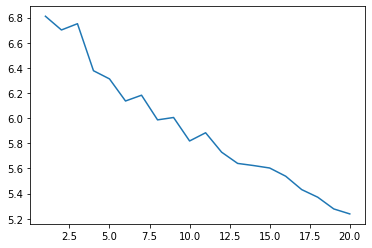

In [0]:
plot_loss_history(ablation_conv3d_history_callback)

#### Final Run

##### Defining model

In [0]:
final_conv3d_model = create_conv3d_model()

print(final_conv3d_model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation_6 (Activation)    (None, 30, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 15, 60, 60, 16)    0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 15, 60, 60, 32)    13856     
_________________________________________________________________
activation_7 (Activation)    (None, 15, 60, 60, 32)   

##### Defining generators

In [0]:
final_conv3d_batch_size = 32
final_conv3d_train_generator = DataGenerator(train_path, train_doc, batch_size = final_conv3d_batch_size)
final_conv3d_val_generator = DataGenerator(val_path, val_doc, batch_size = final_conv3d_batch_size)

##### Defining callbacks

In [0]:
final_conv3d_history_callback = LossHistory()

final_conv3d_checkpoint_callback = get_checkpoint_callback('final_conv3d')

final_conv3d_lr_callback = get_reduce_LR_on_plateau_callback()

final_conv3d_early_stopping_callback = get_early_stopping_callback()

final_conv3d_callbacks_list = [final_conv3d_history_callback, final_conv3d_checkpoint_callback, 
                  final_conv3d_lr_callback, final_conv3d_early_stopping_callback]

##### Fitting Model

In [0]:
final_conv3d_model.fit_generator(final_conv3d_train_generator, epochs=50, verbose=1, 
                    validation_data=final_conv3d_val_generator, 
                                 callbacks = final_conv3d_callbacks_list,
                    class_weight=None, workers=1, initial_epoch=0)

Epoch 1/1
42/42 [==============================] - 358s 9s/step - loss: 6.6827 - categorical_accuracy: 0.2674 - val_loss: 6.2508 - val_categorical_accuracy: 0.3365

Epoch 00001: val_categorical_accuracy improved from -inf to 0.33654, saving model to final_conv3d_model_init_2020-03-3008_57_22.735596/final_conv3d_model-00001-6.68150-0.26998-6.25077-0.33654.h5


#### Evaluating Model

Final Model has been saved at : https://drive.google.com/file/d/1dNu_IITQFnRozWbpKqBhdDuwwqQkpkHw/view?usp=sharing

In [0]:
final_conv3d_batch_size = 32
final_conv3d_val_generator = DataGenerator(val_path, val_doc, batch_size = final_conv3d_batch_size)
model_path = 'generated_models/final_conv3d_model'
download_saved_model('1dNu_IITQFnRozWbpKqBhdDuwwqQkpkHw', model_path)
evaluate_model(model_path, final_conv3d_val_generator)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 60, 60, 16)    0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 60, 60, 32)    13856     
_________________________________________________________________
activation_2 (Activation)    (None, 15, 60, 60, 32)   

### Architecture 2 : ConvLSTM2D

#### Defining Model

In [0]:
def create_conv_lstm_model(learning_rate = 0.01):

    model = Sequential()

    model.add(ConvLSTM2D(filters=16, kernel_size=(3, 3)
                    , recurrent_activation='hard_sigmoid'
                    , activation='tanh'
                    , padding='same'
                      , input_shape=input_shape,
                      return_sequences=True))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(3, 3))))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters=32, kernel_size=(3, 3)
                    , recurrent_activation='hard_sigmoid'
                    , activation='tanh'
                    , padding='valid'
                    , return_sequences=True))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(3, 3))))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters=64, kernel_size=(3, 3)
                    , recurrent_activation='hard_sigmoid'
                    , activation='tanh'
                    , padding='valid'
                    , return_sequences=True))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(3, 3))))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(Flatten())

    model.add(Dense(128,kernel_regularizer=l2(0.01)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    optimizer = optimizers.SGD(lr=learning_rate, clipnorm=1., momentum = 0.8, nesterov=False)
    model.compile(loss="categorical_crossentropy",
              optimizer=optimizer,
              metrics=["categorical_accuracy"]) 

    return model

#### Ablation Experiment

##### Defining model

In [13]:
ablation_conv_lstm_model = create_conv_lstm_model(0.005)

print(ablation_conv_lstm_model.summary())













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_1 (ConvLSTM2D)  (None, 30, 120, 120, 16)  11008     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 30, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 40, 40, 16)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 40, 40, 16)    0         
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 30, 38, 38, 32)    55424     
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 38, 38, 32)    12

##### Defining generators

In [0]:
ablation_conv_lstm_batch_size = 16
ablation_conv_lstm_train_generator = DataGenerator(train_path, train_doc, 100, batch_size = ablation_conv_lstm_batch_size)
ablation_conv_lstm_val_generator = DataGenerator(val_path, val_doc, 100, batch_size = ablation_conv_lstm_batch_size)

##### Defining callbacks

In [0]:
ablation_conv_lstm_history_callback = LossHistory()

ablation_conv_lstm_callbacks_list = [ablation_conv_lstm_history_callback]

##### Fitting Model

In [16]:
ablation_conv_lstm_model.fit_generator(ablation_conv_lstm_train_generator, epochs=20, verbose=1, 
                    validation_data=ablation_conv_lstm_val_generator, 
                                    callbacks = ablation_conv_lstm_callbacks_list,
                    class_weight=None, workers=1, initial_epoch=0)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/20
13/13 [==============================] - 74s 6s/step - loss: 5.1973 - categorical_accuracy: 0.1970 - val_loss: 4.4911 - val_categorical_accuracy: 0.2500
Epoch 2/20
13/13 [==============================] - 69s 5s/step - loss: 4.8866 - categorical_accuracy: 0.2493 - val_loss: 4.3255 - val_categorical_accuracy: 0.2788
Epoch 3/20
13/13 [==============================] - 68s 5s/step - loss: 4.8602 - categorical_accuracy: 0.2452 - val_loss: 4.3800 - val_categorical_accuracy: 0.2212
Epoch 4/20
13/13 [==============================] - 67s 5s/step - loss: 4.4759 - categorical_accuracy: 0.3695 - val_loss: 4.4834 - val_categorical_accuracy: 0.2212
Epoch 5/20
13/13 [==============================] - 66s 5s/step - loss: 4.5492 - categorical_accuracy: 0.2886 - val_loss: 4.3553 - val_categorical_accuracy: 0.2404
Epoch 6/20
13/13 [==============================] - 68s 5s/step - loss: 4.3592 - cat

##### Plotting loss history

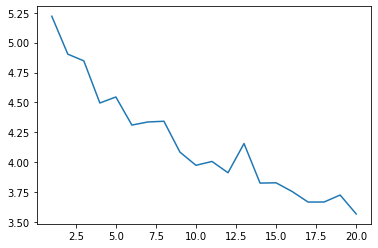

In [17]:
plot_loss_history(ablation_conv_lstm_history_callback)

#### Final Run

##### Defining model

In [0]:
final_conv_lstm_model = create_conv_lstm_model(0.005)

print(final_conv_lstm_model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_7 (ConvLSTM2D)  (None, 30, 120, 120, 16)  11008     
_________________________________________________________________
time_distributed_19 (TimeDis (None, 30, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_20 (TimeDis (None, 30, 40, 40, 16)    0         
_________________________________________________________________
time_distributed_21 (TimeDis (None, 30, 40, 40, 16)    0         
_________________________________________________________________
conv_lst_m2d_8 (ConvLSTM2D)  (None, 30, 38, 38, 32)    55424     
_________________________________________________________________
time_distributed_22 (TimeDis (None, 30, 38, 38, 32)    128       
_________________________________________________________________
time_distributed_23 (TimeDis (None, 30, 12, 12, 32)   

##### Defining generators

In [0]:
final_conv_lstm_batch_size = 16
final_conv_lstm_train_generator = DataGenerator(train_path, train_doc, batch_size = final_conv_lstm_batch_size)
final_conv_lstm_val_generator = DataGenerator(val_path, val_doc, batch_size = final_conv_lstm_batch_size)

##### Defining callbacks

In [0]:
final_conv_lstm_history_callback = LossHistory()

final_conv_lstm_checkpoint_callback = get_checkpoint_callback('final_conv_lstm')

final_conv_lstm_lr_callback = get_reduce_LR_on_plateau_callback(callback_monitor_metric = 'val_categorical_accuracy')

final_conv_lstm_early_stopping_callback = get_early_stopping_callback()

final_conv_lstm_lr_schedular = get_learning_rate_schedular()

final_conv_lstm_callbacks_list = [final_conv_lstm_history_callback, final_conv_lstm_checkpoint_callback, 
                  final_conv_lstm_lr_callback, final_conv_lstm_early_stopping_callback, final_conv_lstm_lr_schedular]

##### Fitting Model

In [0]:
final_conv_lstm_model.fit_generator(final_conv_lstm_train_generator, epochs=50, verbose=1, 
                    validation_data=final_conv_lstm_val_generator, 
                                    callbacks = final_conv_lstm_callbacks_list,
                    class_weight=None, workers=1, initial_epoch=0)

Epoch 1/1

Epoch 00001: LearningRateScheduler setting learning rate to 0.004999999888241291.
83/83 [==============================] - 391s 5s/step - loss: 4.8691 - categorical_accuracy: 0.2474 - val_loss: 4.0778 - val_categorical_accuracy: 0.3750

Epoch 00001: val_categorical_accuracy improved from -inf to 0.37500, saving model to /content/drive/My Drive/final_conv_lstm_model_init_2020-03-3008_57_22.735596/final_conv_lstm_model-00001-4.86985-0.24736-4.07780-0.37500.h5


#### Evaluating Model

Final Model has been saved at : https://drive.google.com/file/d/1DzKXDy30iQqX6TIZ9TihTJ4ID0zYJLJ5/view?usp=sharing

In [0]:
final_conv_lstm_batch_size = 16
final_conv_lstm_val_generator = DataGenerator(val_path, val_doc, batch_size = final_conv_lstm_batch_size)
model_path = 'generated_models/final_conv_lstm_model'
download_saved_model('1DzKXDy30iQqX6TIZ9TihTJ4ID0zYJLJ5', model_path)
evaluate_model(model_path, final_conv_lstm_val_generator)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_7 (ConvLSTM2D)  (None, 30, 120, 120, 16)  11008     
_________________________________________________________________
time_distributed_19 (TimeDis (None, 30, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_20 (TimeDis (None, 30, 40, 40, 16)    0         
_________________________________________________________________
time_distributed_21 (TimeDis (None, 30, 40, 40, 16)    0         
_________________________________________________________________
conv_lst_m2d_8 (ConvLSTM2D)  (None, 30, 38, 38, 32)    55424     
_________________________________________________________________
time_distributed_22 (TimeDis (None, 30, 38, 38, 32)    128       
_________________________________________________________________
time_distributed_23 (TimeDis (None, 30, 12, 12, 32)   

### Architecture 3 : CNN + LSTM

#### Defining Model

In [0]:
def create_cnn_lstm_model(input_shape, num_classes, learning_rate = 0.01, use_mobilenet = True):
    video = Input(shape= input_shape)
    
    if use_mobilenet:
        cnn_base = applications.mobilenet_v2.MobileNetV2(input_shape=(input_shape[1:]),
                     weights="imagenet",
                     include_top=False)
    else:
        cnn_base = applications.resnet50.ResNet50(input_shape=(input_shape[1:]),
                     weights="imagenet",
                     include_top=False) 
        
    cnn_out = GlobalAveragePooling2D()(cnn_base.output)
    cnn = Model(input=cnn_base.input, output=cnn_out)
    cnn.trainable = False
    encoded_frames = TimeDistributed(cnn)(video)
    encoded_sequence = Dropout(0.2)(LSTM(64)(encoded_frames))
    hidden_layer = Dropout(0.5)(Dense(output_dim=128, activation="relu")(encoded_sequence))
    outputs = Dense(output_dim=num_classes, activation="softmax")(hidden_layer)
    model = Model([video], outputs)
    optimizer = optimizers.SGD(lr=learning_rate, clipnorm=1., momentum = 0.8)
    model.compile(loss="categorical_crossentropy",
                  optimizer=optimizer,
                  metrics=["categorical_accuracy"]) 
    
    return model

#### Type 1 : ResNet + LSTM

##### Ablation Experiment

###### Defining model

In [19]:
ablation_resnet_cnn_lstm_model = create_cnn_lstm_model(input_shape, num_classes, 0.005, use_mobilenet = False)

print(ablation_resnet_cnn_lstm_model.summary())


94658560/94653016 [==============================] - 1s 0us/step
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 30, 120, 120, 3)   0         
_________________________________________________________________
time_distributed_10 (TimeDis (None, 30, 2048)          23587712  
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                540928    
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
___________________________________________________________

###### Defining generators

In [0]:
ablation_resnet_cnn_lstm_batch_size = 8
ablation_resnet_cnn_lstm_train_generator = DataGenerator(train_path, train_doc, 100, batch_size = ablation_resnet_cnn_lstm_batch_size, 
                                              preprocess_for_pretrained_resnet = True)
ablation_resnet_cnn_lstm_val_generator = DataGenerator(val_path, val_doc, 100, batch_size = ablation_resnet_cnn_lstm_batch_size, 
                                            preprocess_for_pretrained_resnet = True)

###### Defining callbacks

In [0]:
ablation_resnet_cnn_lstm_history_callback = LossHistory()

ablation_resnet_cnn_lstm_callbacks_list = [ablation_resnet_cnn_lstm_history_callback]

###### Fitting Model

In [22]:
ablation_resnet_cnn_lstm_model.fit_generator(ablation_resnet_cnn_lstm_train_generator, epochs=20, verbose=1, 
                    validation_data=ablation_resnet_cnn_lstm_val_generator, 
                                    callbacks = ablation_resnet_cnn_lstm_callbacks_list,
                    class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
25/25 [==============================] - 80s 3s/step - loss: 1.7226 - categorical_accuracy: 0.1650 - val_loss: 1.6163 - val_categorical_accuracy: 0.1635
Epoch 2/20
25/25 [==============================] - 69s 3s/step - loss: 1.6427 - categorical_accuracy: 0.2000 - val_loss: 1.5929 - val_categorical_accuracy: 0.1923
Epoch 3/20
25/25 [==============================] - 66s 3s/step - loss: 1.6161 - categorical_accuracy: 0.2400 - val_loss: 1.5699 - val_categorical_accuracy: 0.2692
Epoch 4/20
25/25 [==============================] - 69s 3s/step - loss: 1.5647 - categorical_accuracy: 0.2600 - val_loss: 1.5525 - val_categorical_accuracy: 0.2500
Epoch 5/20
25/25 [==============================] - 65s 3s/step - loss: 1.5119 - categorical_accuracy: 0.2950 - val_loss: 1.5364 - val_categorical_accuracy: 0.3173
Epoch 6/20
25/25 [==============================] - 65s 3s/step - loss: 1.4652 - categorical_accuracy: 0.3150 - val_loss: 1.5270 - val_categorical_accuracy: 0.2885
Epoch 7/20
25/25

###### Plotting loss history

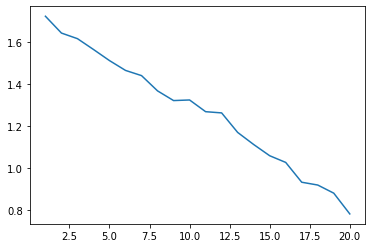

In [23]:
plot_loss_history(ablation_resnet_cnn_lstm_history_callback)

##### Final Run

###### Defining model

In [0]:
final_resnet_cnn_lstm_model = create_cnn_lstm_model(input_shape, num_classes, 0.005, use_mobilenet = False)

print(final_resnet_cnn_lstm_model.summary())

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 30, 120, 120, 3)   0         
_________________________________________________________________
time_distributed_29 (TimeDis (None, 30, 2048)          23587712  
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                540928    
_________________________________________________________________
dropout_23 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_24 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 5)                 645 

###### Defining generators

In [0]:
final_resnet_cnn_lstm_batch_size = 8
final_resnet_cnn_lstm_train_generator = DataGenerator(train_path, train_doc, batch_size = final_resnet_cnn_lstm_batch_size, 
                                              preprocess_for_pretrained_resnet = True)
final_resnet_cnn_lstm_val_generator = DataGenerator(val_path, val_doc, batch_size = final_resnet_cnn_lstm_batch_size, 
                                            preprocess_for_pretrained_resnet = True)

###### Defining callbacks

In [0]:
final_resnet_cnn_lstm_history_callback = LossHistory()

final_resnet_cnn_lstm_checkpoint_callback = get_checkpoint_callback('final_resnet_cnn_lstm')

final_resnet_cnn_lstm_lr_callback = get_reduce_LR_on_plateau_callback()

final_resnet_cnn_lstm_early_stopping_callback = get_early_stopping_callback()

final_resnet_cnn_lstm_lr_schedular = get_learning_rate_schedular()

final_resnet_cnn_lstm_callbacks_list = [final_resnet_cnn_lstm_history_callback, final_resnet_cnn_lstm_checkpoint_callback, 
                  final_resnet_cnn_lstm_lr_callback, final_resnet_cnn_lstm_early_stopping_callback, 
                  final_resnet_cnn_lstm_lr_schedular]

###### Fitting Model

In [0]:
final_resnet_cnn_lstm_model.fit_generator(final_resnet_cnn_lstm_train_generator, epochs=50, verbose=1, 
                    validation_data=final_resnet_cnn_lstm_val_generator, 
                                    callbacks = final_resnet_cnn_lstm_callbacks_list,
                    class_weight=None, workers=1, initial_epoch=0)

Epoch 1/1

Epoch 00001: LearningRateScheduler setting learning rate to 0.004999999888241291.
166/166 [==============================] - 389s 2s/step - loss: 1.6185 - categorical_accuracy: 0.2613 - val_loss: 1.4866 - val_categorical_accuracy: 0.3077

Epoch 00001: val_categorical_accuracy improved from -inf to 0.30769, saving model to /content/drive/My Drive/final_resnet_cnn_lstm_model_init_2020-03-3008_57_22.735596/final_resnet_cnn_lstm_model-00001-1.61876-0.26094-1.48655-0.30769.h5


##### Evaluating Model

Final Model has been saved at : https://drive.google.com/file/d/13VGug-pnAsziKURuja_uItOO9yCyml5A/view?usp=sharing

In [0]:
final_resnet_cnn_lstm_batch_size = 8
final_resnet_cnn_lstm_val_generator = DataGenerator(val_path, val_doc, batch_size = final_resnet_cnn_lstm_batch_size,
                                                    preprocess_for_pretrained_resnet = True)
model_path = 'generated_models/final_resnet_cnn_lstm_model'
download_saved_model('13VGug-pnAsziKURuja_uItOO9yCyml5A', model_path)
evaluate_model(model_path, final_resnet_cnn_lstm_val_generator)

Model already downloaded !!
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 30, 120, 120, 3)   0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 30, 2048)          23587712  
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                540928    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (N

#### Type 2 : MobileNet + LSTM Model

##### Ablation Experiment

###### Defining model

In [24]:
ablation_mobilenet_cnn_lstm_model = create_cnn_lstm_model(input_shape, num_classes, 0.005)

print(ablation_mobilenet_cnn_lstm_model.summary())

9412608/9406464 [==============================] - 0s 0us/step
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 30, 120, 120, 3)   0         
_________________________________________________________________
time_distributed_11 (TimeDis (None, 30, 1280)          2257984   
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                344320    
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
______________________________________________________________

###### Defining generators

In [0]:
ablation_mobilenet_cnn_lstm_batch_size = 8
ablation_mobilenet_cnn_lstm_train_generator = DataGenerator(train_path, train_doc, 100, batch_size = ablation_mobilenet_cnn_lstm_batch_size, 
                                              preprocess_for_pretrained_mobilenet = True)
ablation_mobilenet_cnn_lstm_val_generator = DataGenerator(val_path, val_doc, 100, batch_size = ablation_mobilenet_cnn_lstm_batch_size, 
                                            preprocess_for_pretrained_mobilenet = True)

###### Defining callbacks

In [0]:
ablation_mobilenet_cnn_lstm_history_callback = LossHistory()

ablation_mobilenet_cnn_lstm_callbacks_list = [ablation_mobilenet_cnn_lstm_history_callback]

###### Fitting Model

In [27]:
ablation_mobilenet_cnn_lstm_model.fit_generator(ablation_mobilenet_cnn_lstm_train_generator, epochs=20, verbose=1, 
                    validation_data=ablation_mobilenet_cnn_lstm_val_generator, 
                                    callbacks = ablation_mobilenet_cnn_lstm_callbacks_list,
                    class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
25/25 [==============================] - 77s 3s/step - loss: 1.6845 - categorical_accuracy: 0.1750 - val_loss: 1.5932 - val_categorical_accuracy: 0.2019
Epoch 2/20
25/25 [==============================] - 67s 3s/step - loss: 1.6800 - categorical_accuracy: 0.1900 - val_loss: 1.5819 - val_categorical_accuracy: 0.1923
Epoch 3/20
25/25 [==============================] - 65s 3s/step - loss: 1.6130 - categorical_accuracy: 0.2400 - val_loss: 1.5705 - val_categorical_accuracy: 0.2308
Epoch 4/20
25/25 [==============================] - 63s 3s/step - loss: 1.6171 - categorical_accuracy: 0.2900 - val_loss: 1.5629 - val_categorical_accuracy: 0.2308
Epoch 5/20
25/25 [==============================] - 67s 3s/step - loss: 1.5765 - categorical_accuracy: 0.2650 - val_loss: 1.5554 - val_categorical_accuracy: 0.2212
Epoch 6/20
25/25 [==============================] - 63s 3s/step - loss: 1.5588 - categorical_accuracy: 0.3200 - val_loss: 1.5331 - val_categorical_accuracy: 0.2404
Epoch 7/20
25/25

###### Plotting loss history

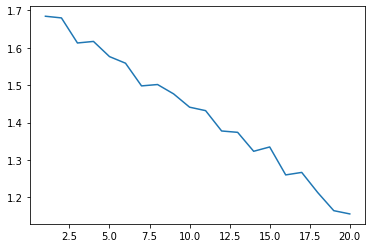

In [28]:
plot_loss_history(ablation_mobilenet_cnn_lstm_history_callback)

##### Final Run

###### Defining model

In [0]:
final_mobilenet_cnn_lstm_model = create_cnn_lstm_model(input_shape, num_classes, 0.005)

print(final_mobilenet_cnn_lstm_model.summary())

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 30, 120, 120, 3)   0         
_________________________________________________________________
time_distributed_31 (TimeDis (None, 30, 1280)          2257984   
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                344320    
_________________________________________________________________
dropout_27 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_28 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 5)                 645 

###### Defining generators

In [0]:
final_mobilenet_cnn_lstm_batch_size = 8
final_mobilenet_cnn_lstm_train_generator = DataGenerator(train_path, train_doc, batch_size = final_mobilenet_cnn_lstm_batch_size, 
                                              preprocess_for_pretrained_mobilenet = True)
final_mobilenet_cnn_lstm_val_generator = DataGenerator(val_path, val_doc, batch_size = final_mobilenet_cnn_lstm_batch_size, 
                                            preprocess_for_pretrained_mobilenet = True)

###### Defining callbacks

In [0]:
final_mobilenet_cnn_lstm_history_callback = LossHistory()

final_mobilenet_cnn_lstm_checkpoint_callback = get_checkpoint_callback('final_mobilenet_cnn_lstm')

final_mobilenet_cnn_lstm_lr_callback = get_reduce_LR_on_plateau_callback()

final_mobilenet_cnn_lstm_early_stopping_callback = get_early_stopping_callback()

final_mobilenet_cnn_lstm_lr_schedular = get_learning_rate_schedular()

final_mobilenet_cnn_lstm_callbacks_list = [final_mobilenet_cnn_lstm_history_callback, final_mobilenet_cnn_lstm_checkpoint_callback, 
                  final_mobilenet_cnn_lstm_lr_callback, final_mobilenet_cnn_lstm_early_stopping_callback, final_mobilenet_cnn_lstm_lr_schedular]

###### Fitting Model

In [0]:
final_mobilenet_cnn_lstm_model.fit_generator(final_mobilenet_cnn_lstm_train_generator, epochs=50, verbose=1, 
                    validation_data=final_mobilenet_cnn_lstm_val_generator, 
                                    callbacks = final_mobilenet_cnn_lstm_callbacks_list,
                    class_weight=None, workers=1, initial_epoch=0)

Epoch 1/1

Epoch 00001: LearningRateScheduler setting learning rate to 0.004999999888241291.
166/166 [==============================] - 388s 2s/step - loss: 1.6318 - categorical_accuracy: 0.2246 - val_loss: 1.4809 - val_categorical_accuracy: 0.3077

Epoch 00001: val_categorical_accuracy improved from -inf to 0.30769, saving model to /content/drive/My Drive/final_mobilenet_cnn_lstm_model_init_2020-03-3008_57_22.735596/final_mobilenet_cnn_lstm_model-00001-1.63177-0.22474-1.48086-0.30769.h5


##### Evaluating Model

Final Model has been saved at : https://drive.google.com/file/d/1vwU01OJ8tpVKYu0Y3_9GQ2DKaLzOYHhP/view?usp=sharing 

In [29]:
final_mobilenet_cnn_lstm_batch_size = 8
final_mobilenet_cnn_lstm_val_generator = DataGenerator(val_path, val_doc, batch_size = final_mobilenet_cnn_lstm_batch_size,
                                                       preprocess_for_pretrained_mobilenet = True)
model_path = 'generated_models/final_mobilenet_cnn_lstm_model'
download_saved_model('1vwU01OJ8tpVKYu0Y3_9GQ2DKaLzOYHhP', model_path)
evaluate_model(model_path, final_mobilenet_cnn_lstm_val_generator)

Model already downloaded !!
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 30, 120, 120, 3)   0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 30, 1280)          2257984   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                344320    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (N

## Step 5 - Final Model

Since the prediction model for gesture recognition will possibly be deployed within webcam having limited resources. Hence, number of parameters along is an important factor in deciding the final model. Based on above presented evidence, model based on Conv3D architecture is providing good accuracy with least amount of parameters, therefore, the same is proposed as final model among all implementations.

In [0]:
final_batch_size = 32
final_val_generator = DataGenerator(val_path, val_doc, batch_size = final_batch_size)
model_path = 'final_conv3d_model-00033-3.01628-0.98492-3.15547-0.94231'
evaluate_model(model_path, final_val_generator)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 60, 60, 16)    0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 60, 60, 32)    13856     
_________________________________________________________________
activation_2 (Activation)    (None, 15, 60, 60, 32)   